## Load all libraries and define functions

In [1]:
library(RCTD)
library(Matrix)
library(Seurat)
library(SeuratData)
library(ggplot2)
library(patchwork)
library(dplyr)
options(repr.plot.width = 20, repr.plot.height = 10)

Attaching SeuratObject

Attaching sp

Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the 

In [3]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] dplyr_1.0.10              patchwork_1.1.2          
 [3] ggplot2_3.3.6             stxBrain.SeuratData_0.1.1
 [5] pbmc3k.SeuratData_3.1.4   panc8.SeuratData_3.0.2   
 [7] SeuratData_0.2.1          sp_1.5-0                 
 [9] SeuratObject_4.1.2        Seurat_4.2.0             
[11] Matrix_1.5-1              RCTD_2.0.0

In [2]:
## Functions
## Create Seurat object function 
create_seurat_spatial <- function(datadir, puck_no) {
    mtx_file <- file.path(datadir, paste0(puck_no, '.matched.digital_expression_matrix.mtx.gz'))
    barcodes_file <- file.path(datadir,  paste0(puck_no, '.matched.digital_expression_barcodes.tsv.gz'))
    coords_file <- file.path(datadir,  paste0('barcode_matching/', puck_no, '_barcode_matching.txt.gz' ))
    features_file <- file.path(datadir,  paste0(puck_no, '.matched.digital_expression_features.tsv.gz'))
    counts <- readMM(mtx_file)
    counts <- as(counts, "dgCMatrix")
    barcodes <- read.csv(barcodes_file, header = F)
    pre_coords <- read.csv(coords_file, header = F, sep = '\t')
    pre_coords <- pre_coords[!duplicated(pre_coords[,2]), ]
    coords <- data.frame(pre_coords[,3:4])
    rownames(coords) <- pre_coords[,2]
    colnames(coords) <- c("xcoord", "ycoord")
    features <- read.csv(features_file, header = F, sep = '\t')
    rownames(counts) <- features[,2]
    colnames(counts) <- barcodes[,1]
    seurat <- CreateSeuratObject(counts = counts, project = puck_no, assay = 'Spatial')
    seurat@images$image <- new(Class = 'SlideSeq', assay = "Spatial", coordinates = coords)
    plot1 <- VlnPlot(seurat, features = "nCount_Spatial", pt.size = 0, log = TRUE) + NoLegend()
    seurat$log_nCount_Spatial <- log(seurat$nCount_Spatial)
    plot2 <- SpatialFeaturePlot(seurat, features = "log_nCount_Spatial") + theme(legend.position = "right")
    print(wrap_plots(plot1, plot2))
    ggsave("seurat_object_raw.pdf", width = 15, height = 10)
    return(seurat)
}

#Create RCTD object from raw data
create_RCTD_spatialRNA <- function(datadir, puck_no) {
    mtx_file <- file.path(datadir, paste0(puck_no, '.matched.digital_expression_matrix.mtx.gz'))
    barcodes_file <- file.path(datadir,  paste0(puck_no, '.matched.digital_expression_barcodes.tsv.gz'))
    coords_file <- file.path(datadir,  paste0('barcode_matching/', puck_no, '_barcode_matching.txt.gz' ))
    features_file <- file.path(datadir,  paste0(puck_no, '.matched.digital_expression_features.tsv.gz'))
  counts <- readMM(mtx_file)
  barcodes <- read.csv(barcodes_file, header = F)
  pre_coords <- read.csv(coords_file, header = F, sep = '\t')
  pre_coords <- pre_coords[!duplicated(pre_coords[,2]), ]
  coords <- data.frame(pre_coords[,3:4])
  rownames(coords) <- pre_coords[,2]
  colnames(coords) <- c("xcoord", "ycoord")
  features <- read.csv(features_file, header = F, sep = '\t')
  rownames(counts) <- features[,2]
  colnames(counts) <- barcodes[,1]
  puck <- SpatialRNA(coords,counts)
  print(plot_puck_continuous(puck, barcodes = colnames(puck@counts), puck@nUMI, ylimit = c(0,round(quantile(puck@nUMI,0.9))), title ='plot of nUMI')) 
  ggsave("spatialRNA_object_raw.pdf", width = 15, height = 10)
  return(puck)
}

#Covert Seurat Object to RCTD SpatialRNA object
covert_seurat_to_spatialRNA <- function(seurat_object) {
    coords <- seurat_object@images$image@coordinates[,1:2]
    counts <- seurat_object@assays$Spatial@counts
    puck <- SpatialRNA(coords,counts)
    print(plot_puck_continuous(puck, barcodes = colnames(puck@counts), puck@nUMI, ylimit = c(0,round(quantile(puck@nUMI,0.9))), title ='plot of nUMI')) 
    ggsave("spatialRNA_object_cropped.pdf")
    UMI <- data.frame(puck = puck_name, nUMI = puck@nUMI)
    #p1 <- ggplot(UMI, aes(x = nUMI)) + geom_density(fill="#69b3a2", color="#e9ecef", alpha=0.8) + ggtitle("nUMI distribution") + theme_classic() + scale_x_log10()
    p1 <- ggplot(UMI, aes(x = nUMI)) + geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.8) + ggtitle("nUMI distribution") + theme_classic() + scale_x_log10()
    print(p1)
    ggsave("nUMI_histogram_processed.pdf")
    return(puck)
}

## Create seurat objects 

In [409]:
#Enter the folder name and puck name as in the google cloud bucket here

folder_name <- "2021-11-13_Puck_211008_09"
puck_name <- "Puck_211008_09"

## Transfer all relevant files of desired puck to VM
system(paste0("gsutil -m cp -R gs://lymphoma-slideseq-data-broad/data/slideseq/",folder_name, " /home/vshanmug/data"))

##Set appropriate working directory
system(paste0("mkdir /home/vshanmug/data/", folder_name, "/processed"))
setwd(paste0("/home/vshanmug/data/", folder_name, "/processed"))

seurat <- create_seurat_spatial(datadir = paste0("/home/vshanmug/data/", folder_name), puck_no = puck_name)

##Use this for Seurat objects that have already been created - pilot samples 
#seurat <- readRDS("/home/vshanmug/data/2021-01-20_Puck_200906_25_CHL2/CHL2_25.rds")

## Crop pucks to remove stray beads

Saving 6.67 x 6.67 in image



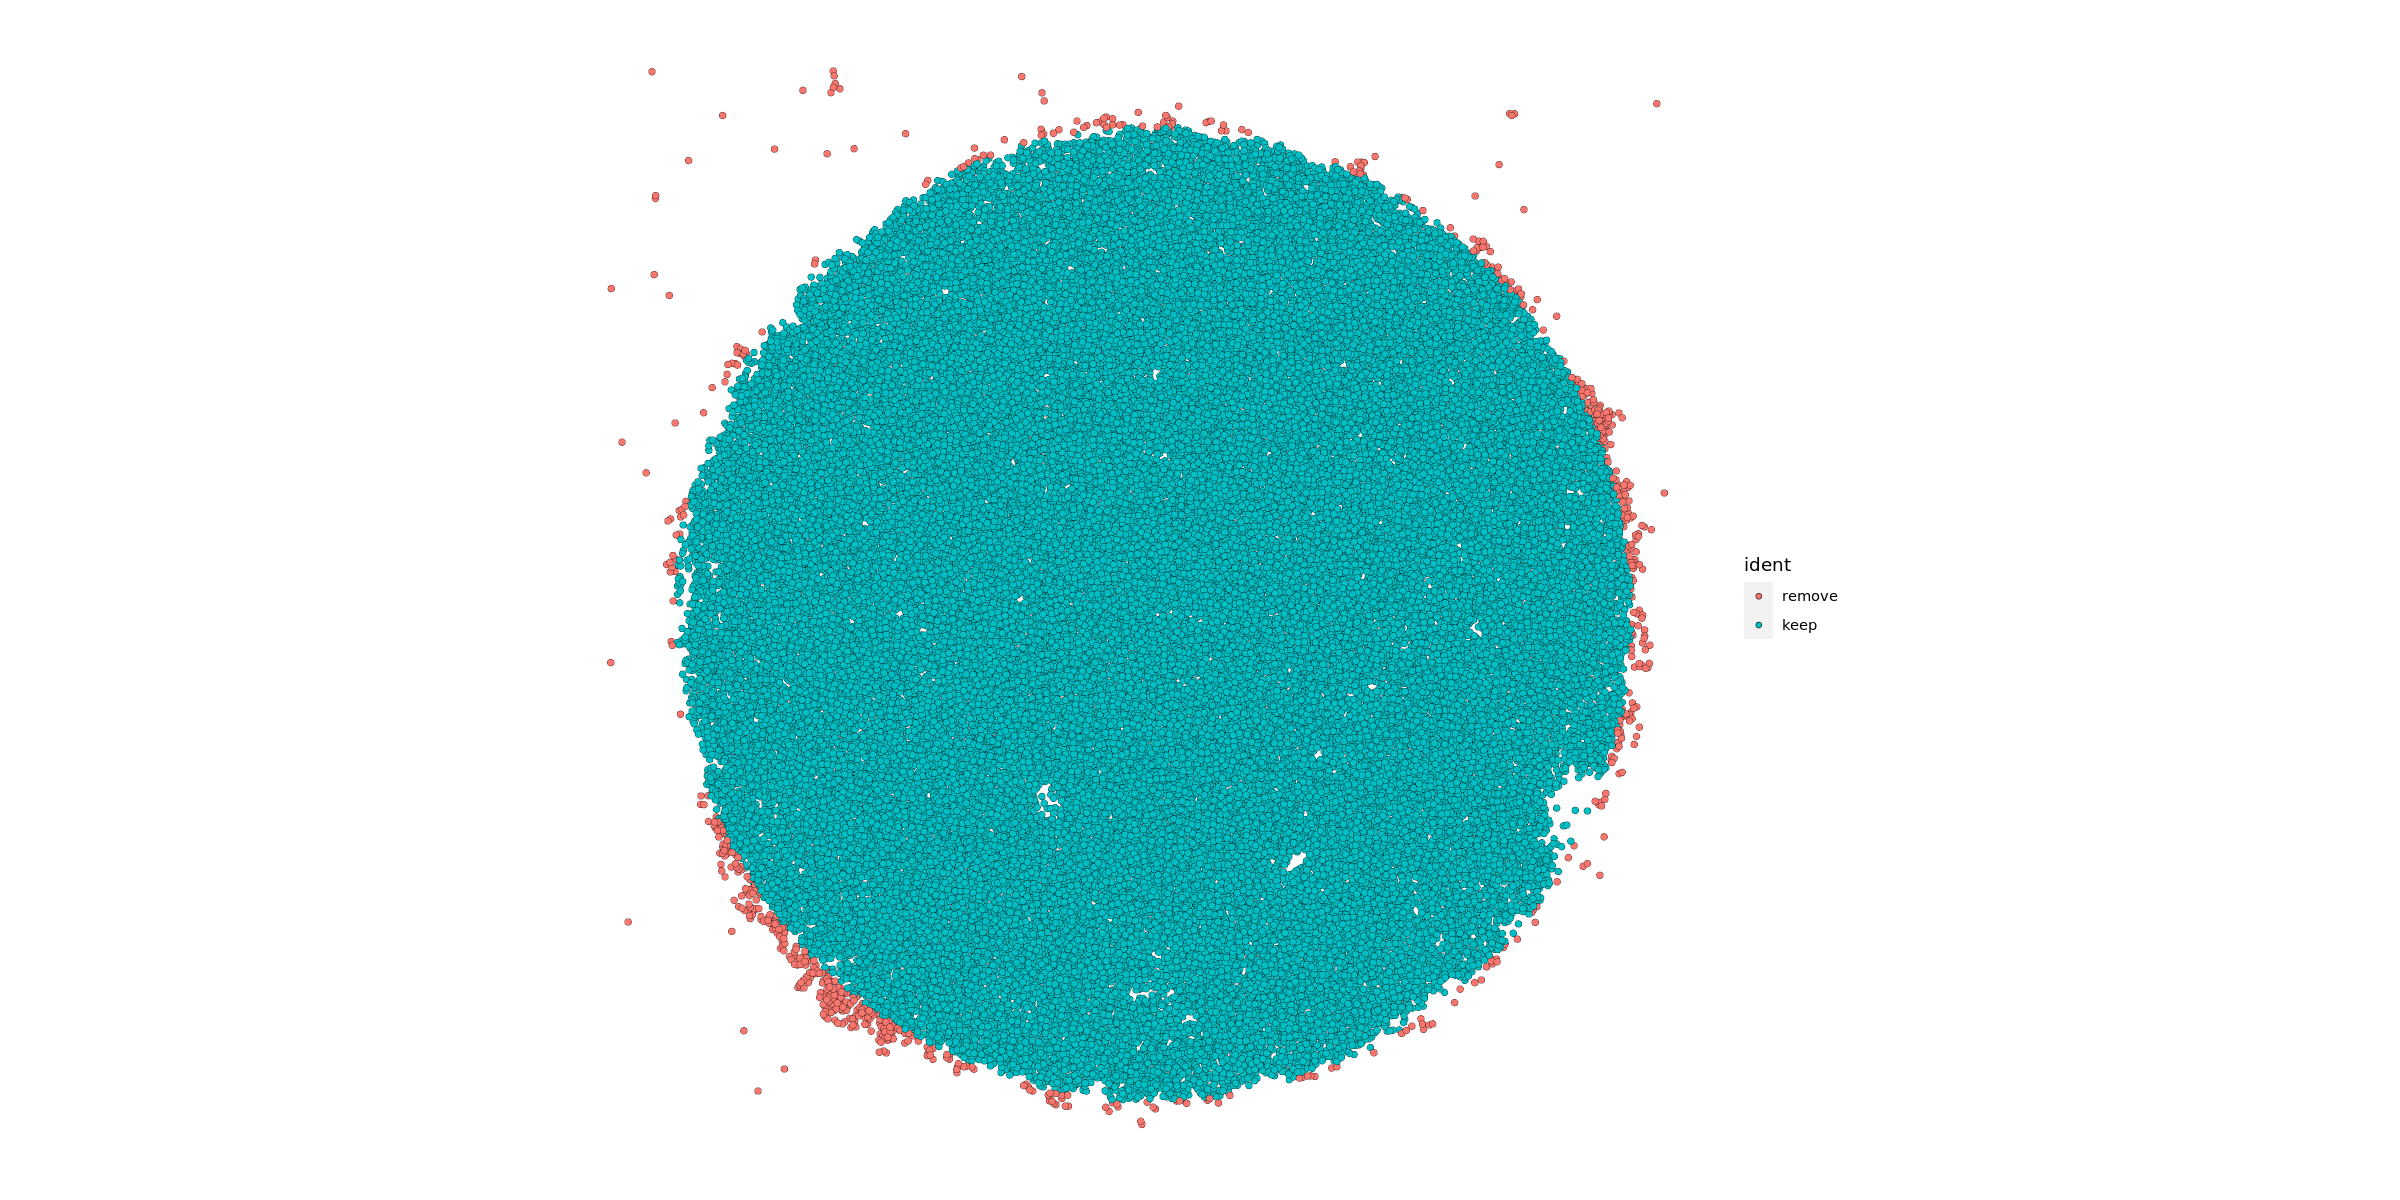

In [415]:
#Seurat function to crop puck 
#Center is around 2500, 2500 but varies for each puck
seurat_cropped <- FilterSlideSeq(object = seurat, radius = 2250, do.plot = TRUE)
##Second step of cropping if needed 
#seurat_cropped <- FilterSlideSeq(object = seurat_cropped, radius = 5500, center = c(6300, 2600), do.plot = TRUE)
ggsave("seurat_object_cropped.pdf")

## Create spatialRNA objects 

Formal class 'SpatialRNA' [package "RCTD"] with 3 slots
  ..@ coords:'data.frame':	54825 obs. of  2 variables:
  .. ..$ x: num [1:54825] 2698 2388 1697 2819 2554 ...
  .. ..$ y: num [1:54825] 438 812 862 614 714 ...
  ..@ counts:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:18495260] 17 18 24 28 57 58 63 74 75 78 ...
  .. .. ..@ p       : int [1:54826] 0 2741 5314 7755 10147 12642 15006 17304 19713 21996 ...
  .. .. ..@ Dim     : int [1:2] 30399 54825
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:30399] "A1BG" "A1BG-AS1" "A1CF" "A2M" ...
  .. .. .. ..$ : chr [1:54825] "TTCCTAACTCATCT-1" "AGCTNTTGCAACTA-1" "TACTCAAACTCTAA-1" "ACTAGCTCAGGTCA-1" ...
  .. .. ..@ x       : num [1:18495260] 1 1 1 3 1 2 1 1 8 1 ...
  .. .. ..@ factors : list()
  ..@ nUMI  : Named num [1:54825] 5616 5013 4896 4677 4574 ...
  .. ..- attr(*, "names")= chr [1:54825] "TTCCTAACTCATCT-1" "AGCTNTTGCAACTA-1" "TACTCAAACTCTAA-1" "ACTAGCTCAGGTCA-1" ...


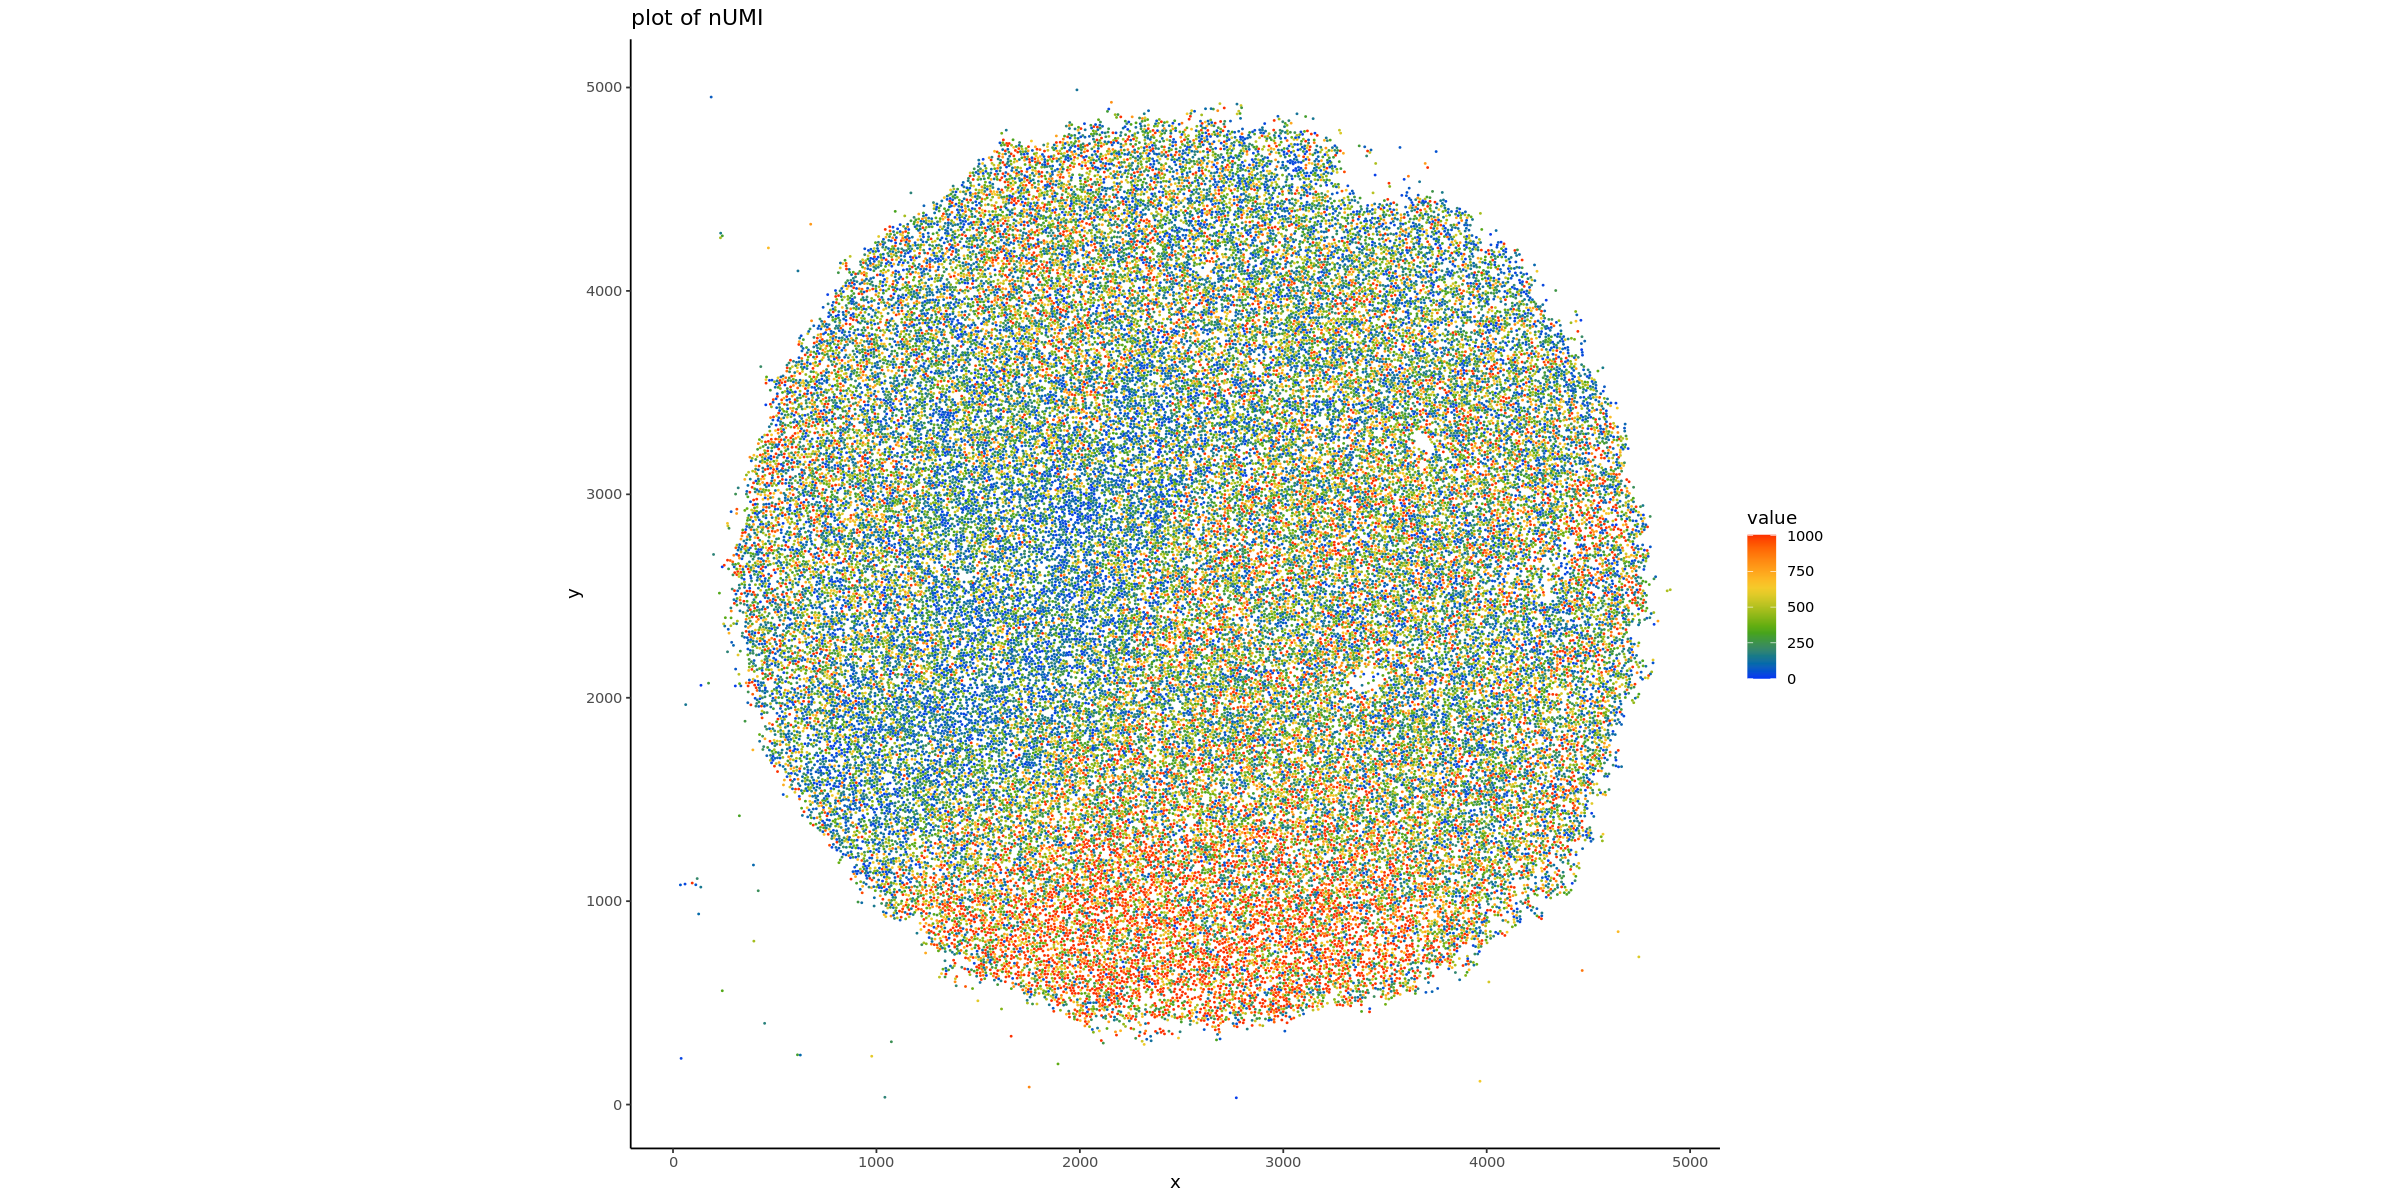

In [416]:
spatialRNA_raw <- create_RCTD_spatialRNA(datadir = paste0("/home/vshanmug/data/", folder_name), puck_no = puck_name)
str(spatialRNA_raw)

Saving 6.67 x 6.67 in image

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Saving 6.67 x 6.67 in image

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



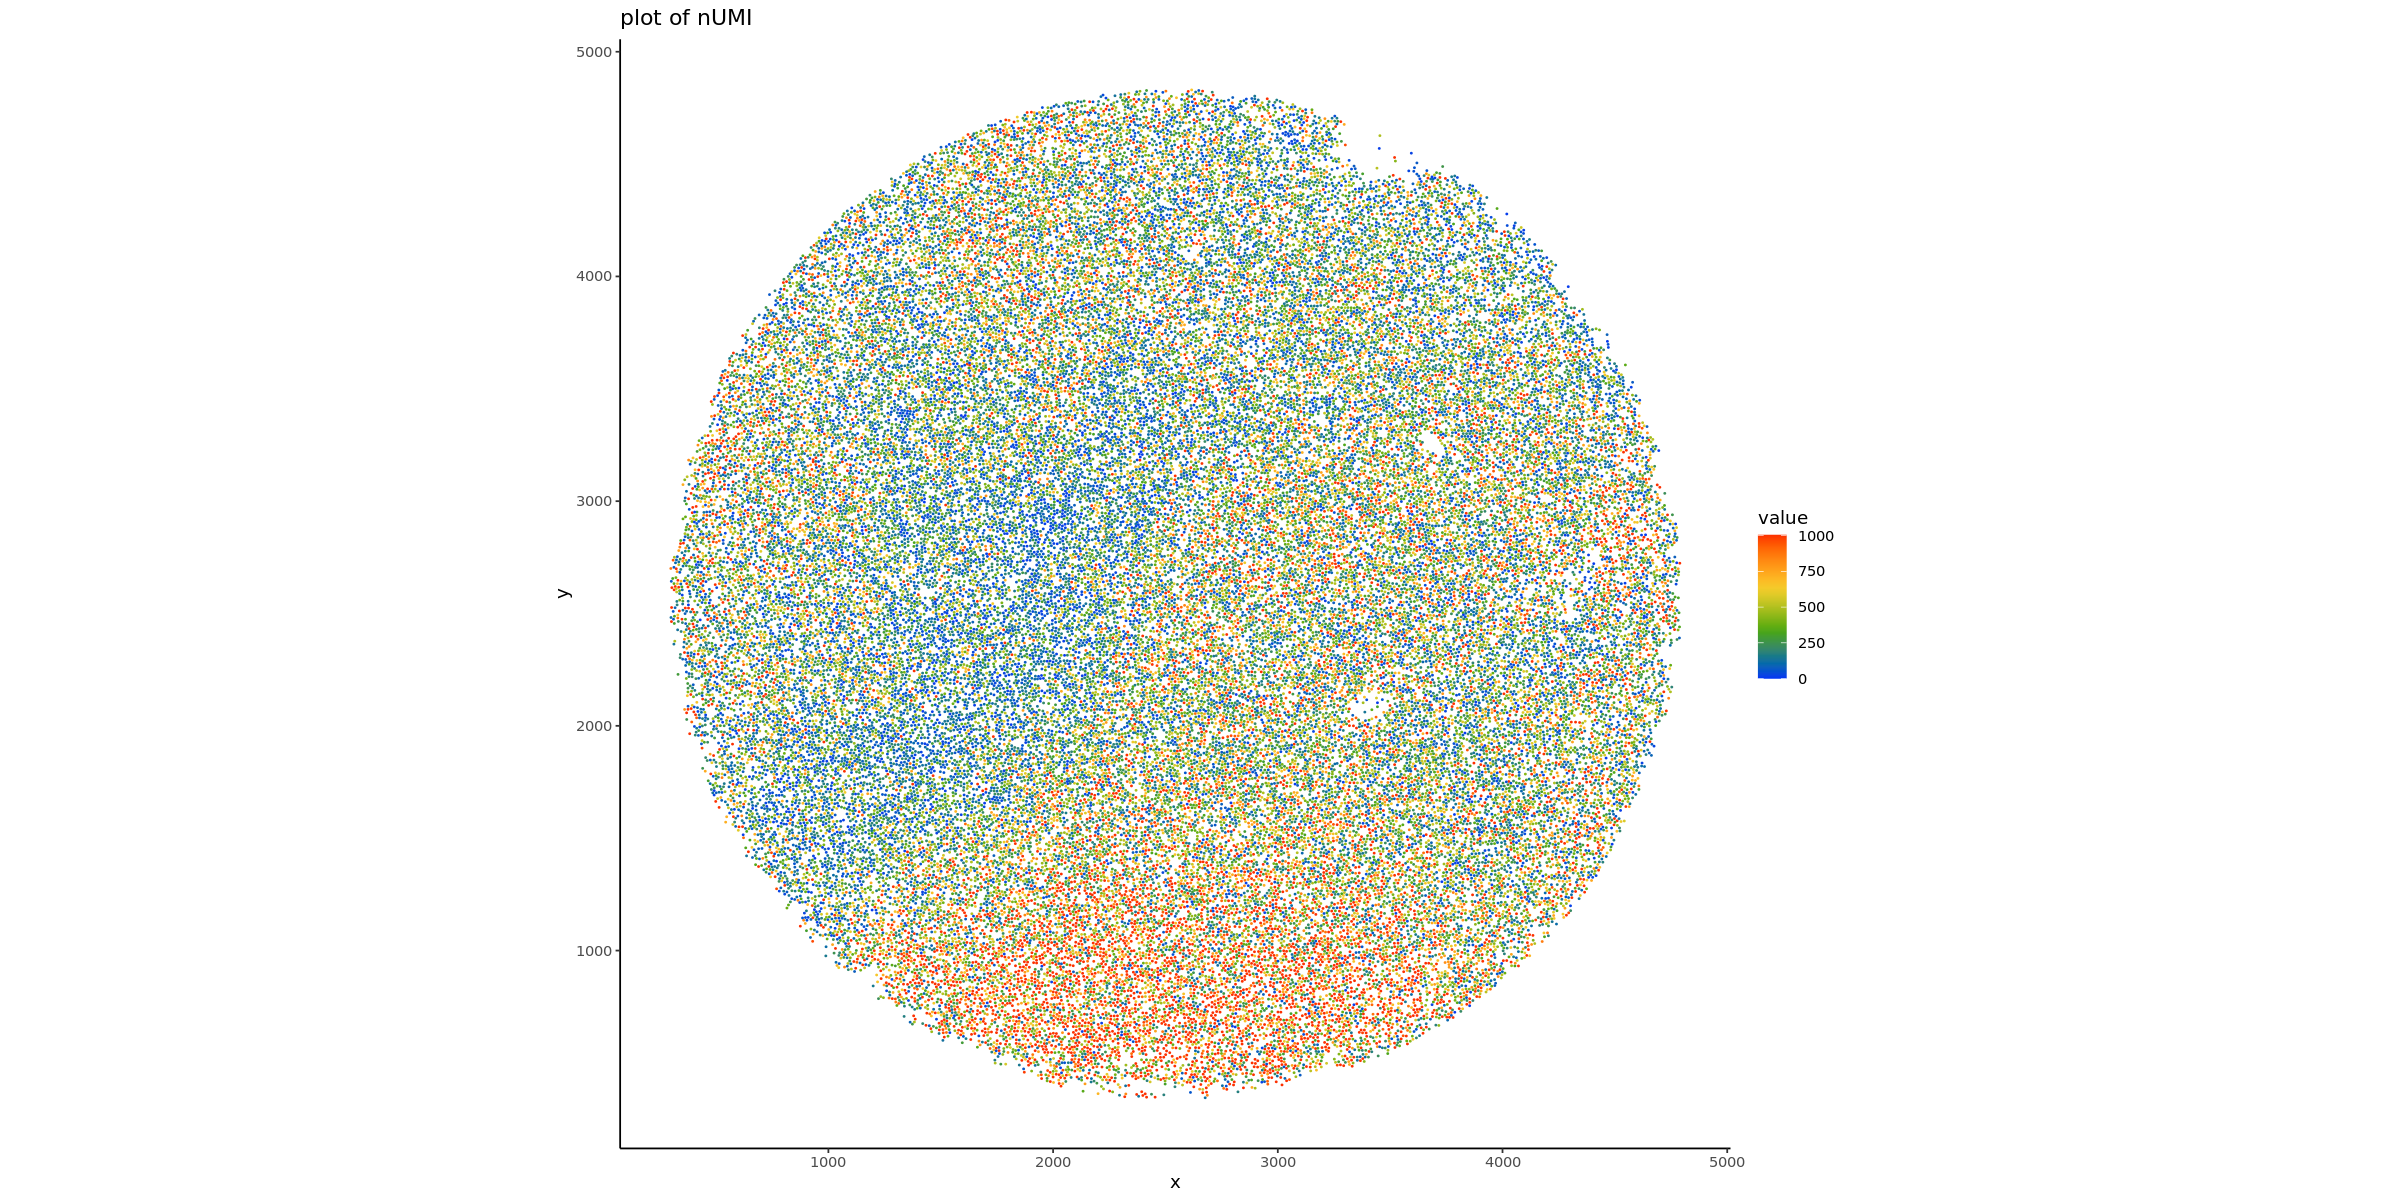

Formal class 'SpatialRNA' [package "RCTD"] with 3 slots
  ..@ coords:'data.frame':	54073 obs. of  2 variables:
  .. ..$ x: num [1:54073] 2698 2388 1697 2819 2554 ...
  .. ..$ y: num [1:54073] 438 812 862 614 714 ...
  ..@ counts:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:18249683] 17 18 24 28 57 58 63 74 75 78 ...
  .. .. ..@ p       : int [1:54074] 0 2741 5314 7755 10147 12642 15006 17304 19713 21996 ...
  .. .. ..@ Dim     : int [1:2] 30399 54073
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:30399] "A1BG" "A1BG-AS1" "A1CF" "A2M" ...
  .. .. .. ..$ : chr [1:54073] "TTCCTAACTCATCT-1" "AGCTNTTGCAACTA-1" "TACTCAAACTCTAA-1" "ACTAGCTCAGGTCA-1" ...
  .. .. ..@ x       : num [1:18249683] 1 1 1 3 1 2 1 1 8 1 ...
  .. .. ..@ factors : list()
  ..@ nUMI  : Named num [1:54073] 5616 5013 4896 4677 4574 ...
  .. ..- attr(*, "names")= chr [1:54073] "TTCCTAACTCATCT-1" "AGCTNTTGCAACTA-1" "TACTCAAACTCTAA-1" "ACTAGCTCAGGTCA-1" ...


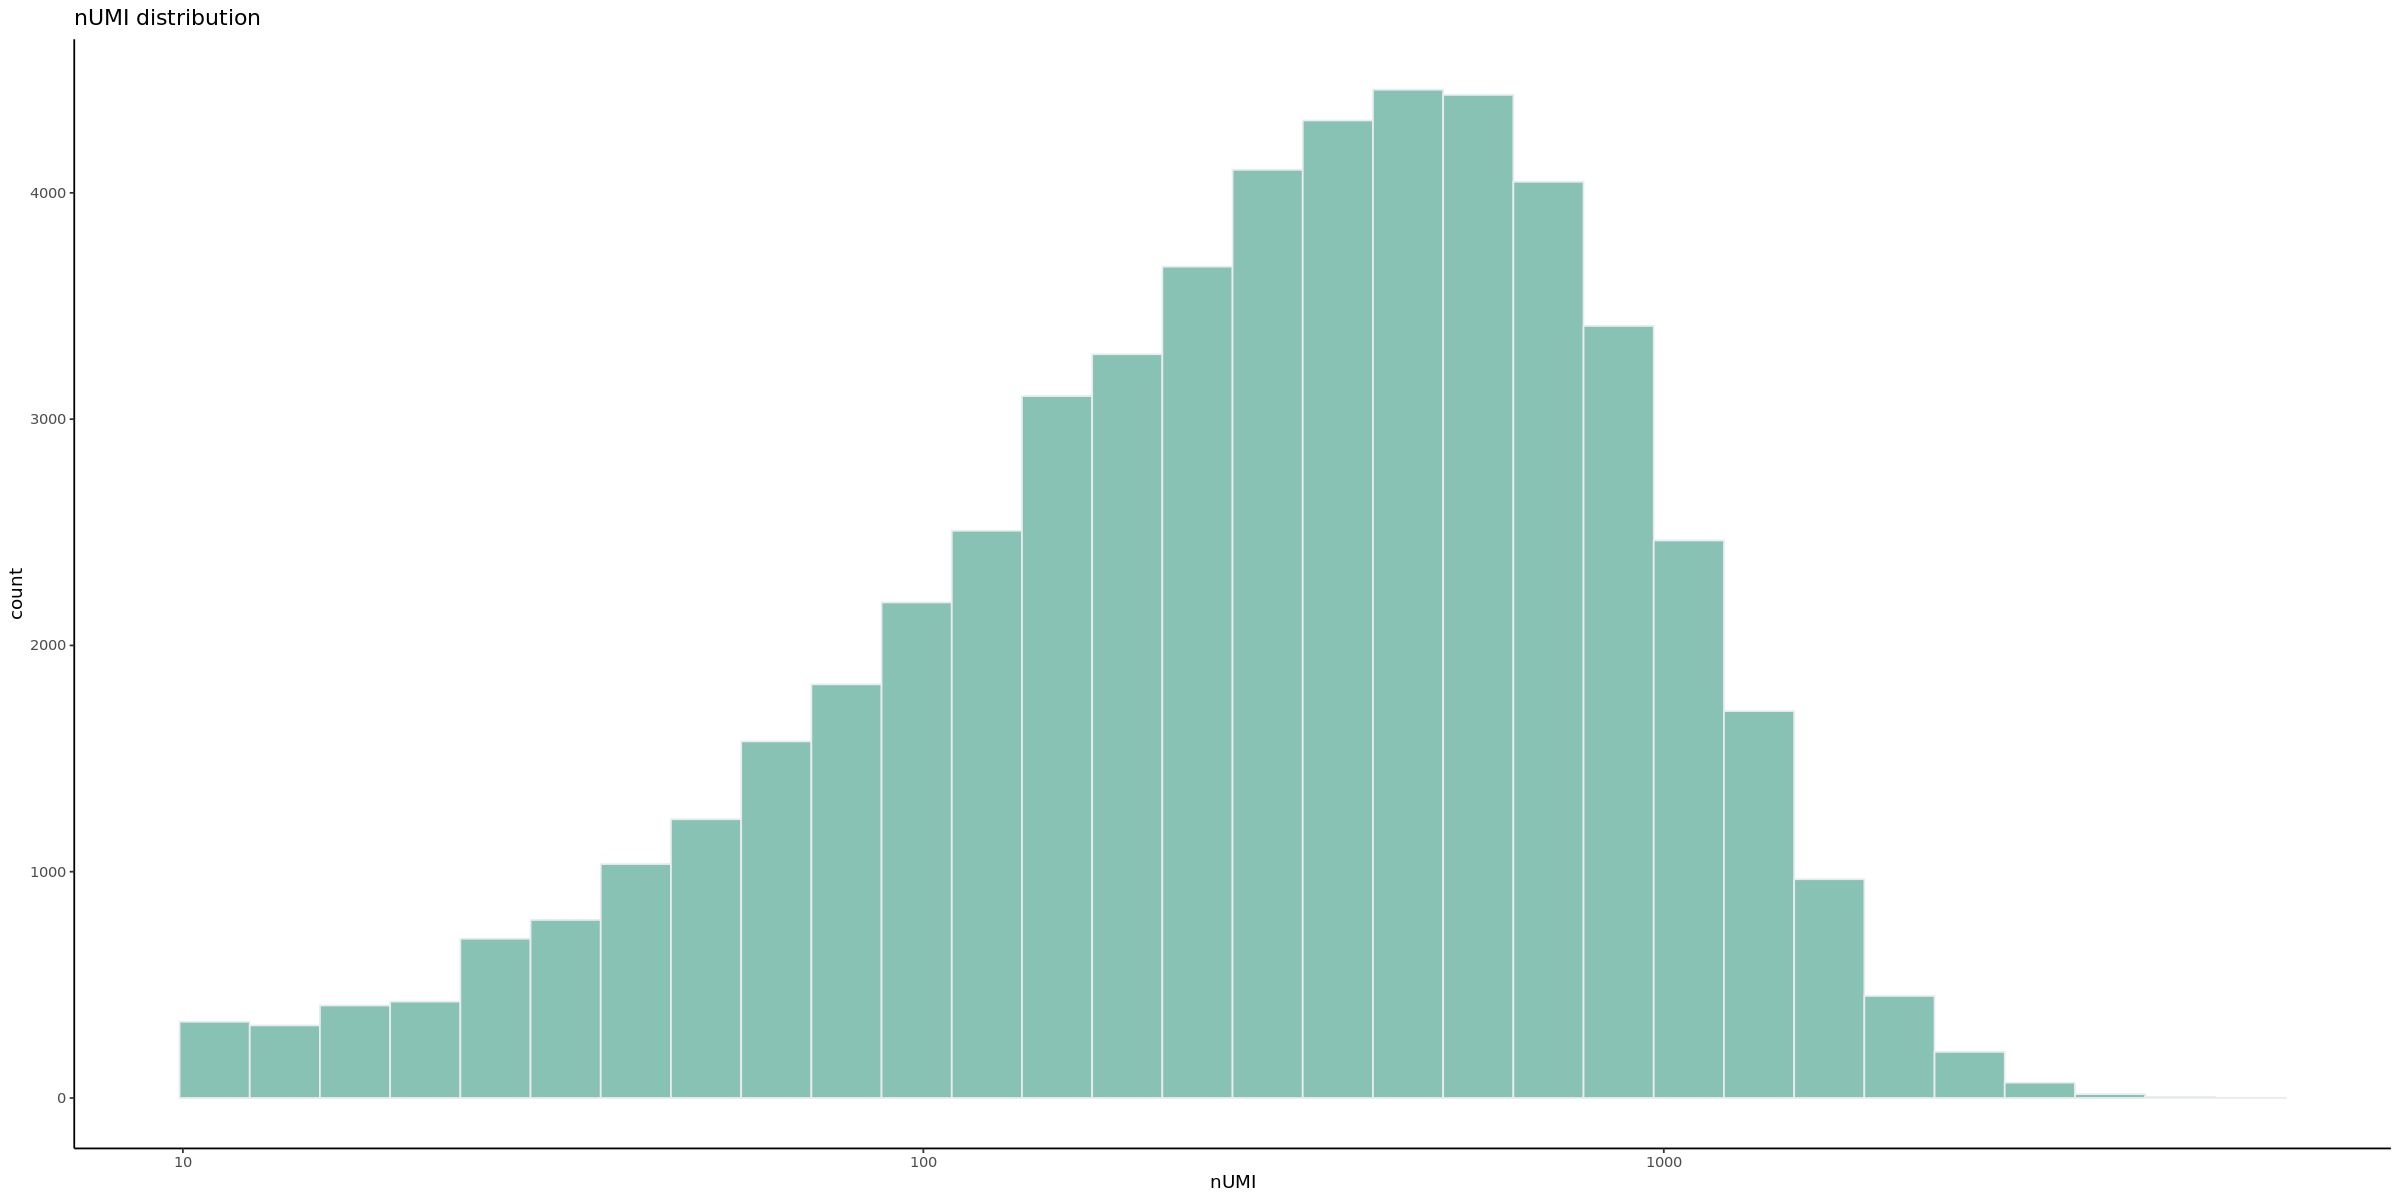

In [417]:
spatialRNA <- covert_seurat_to_spatialRNA(seurat_object = seurat_cropped)
str(spatialRNA)

In [418]:
## Save processed Seurat and RCTD objects on VM
saveRDS(seurat_cropped, paste0("/home/vshanmug/data/", folder_name, "/processed/seurat.rds"))
saveRDS(spatialRNA, paste0("/home/vshanmug/data/", folder_name, "/processed/spatialRNA.rds"))

In [419]:
## Transfer the QC-ed seurat and spatialRNA (RCTD) objects to the google bucket for further analysis

system(paste0("gsutil -m cp -R /home/vshanmug/data/", folder_name, "/processed", " gs://lymphoma-slideseq-data-broad/results/processed_slideseq_data/", folder_name,"/"))


In [420]:
## Remove puck directory
## BE CAREFUL WHEN YOU RUN THIS - ENSURE that folder_name has an assigned value
system(paste0("rm -vrf /home/vshanmug/data/", folder_name), intern = TRUE)

[1] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/Puck_211008_09.matched.digital_expression_barcodes.tsv.gz'"             
  [2] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/Puck_211008_09.all_illumina.ReadQualityMetrics.txt'"                    
  [3] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/Puck_211008_09.all_illumina.bai'"                                       
  [4] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/Puck_211008_09.all_illumina.mapping_rate.txt'"                          
  [5] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/Puck_211008_09.matched.numReads_perCell_XB_mq_10.txt.gz'"               
  [6] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/Puck_211008_09.matched.10_transcripts_mq_10_selected_cells.txt.gz'"     
  [7] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/processed/nUMI_histogram_processed.pdf'"                                
  [8] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/processed/spatialRNA_object_cropped.pdf'"                               
  [9] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/processed/spatialRNA_object_raw.pdf'"                                   
 [10] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/processed/seurat_object_cropped.pdf'"                                   
 [11] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/processed/seurat.rds'"                                                  
 [12] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/processed/spatialRNA.rds'"                                              
 [13] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/processed/seurat_object_raw.pdf'"                                       
 [14] "removed directory '/home/vshanmug/data/2021-11-13_Puck_211008_09/processed'"                                                   
 [15] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/Puck_211008_09.matched.digital_expression_features.tsv.gz'"             
 [16] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample/Puck_211008_09_0.7.digital_expression_summary.txt'"          
 [17] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample/Puck_211008_09_0.6.digital_expression_summary.txt'"          
 [18] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample/Puck_211008_09_0.1.digital_expression_summary.txt'"          
 [19] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample/Puck_211008_09_0.4.digital_expression_summary.txt'"          
 [20] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample/Puck_211008_09_0.3.digital_expression_summary.txt'"          
 [21] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample/Puck_211008_09_0.9.digital_expression_summary.txt'"          
 [22] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample/Puck_211008_09_0.8.digital_expression_summary.txt'"          
 [23] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample/Puck_211008_09_0.2.digital_expression_summary.txt'"          
 [24] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample/Puck_211008_09_0.5.digital_expression_summary.txt'"          
 [25] "removed directory '/home/vshanmug/data/2021-11-13_Puck_211008_09/downsample'"                                                  
 [26] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/Puck_211008_09.all_illumina.bam'"                                       
 [27] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/H7LKLBGXK/L004/Puck_211008_09.unmapped.bam'"                            
 [28] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/H7LKLBGXK/L004/alignment/Puck_211008_09.star.SJ.out.tab'"               
 [29] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/H7LKLBGXK/L004/alignment/Puck_211008_09.adapter_trimming.summary.txt'"  
 [30] "removed '/home/vshanmug/data/2021-11-13_Puck_211008_09/H7LKLBGXK/L004/alignment/